In [24]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from sklearn import metrics

In [25]:
df_anime = pd.read_csv('anime_filtered.csv')

In [26]:
df = df_anime[df_anime.score > 0]

df_cleaned = df[['score', 'type', 'source', 'rating', 'episodes', 'genre', 'scored_by', 'members', 'favorites']]

df_cleaned['genres'] = df_cleaned.genre.str.split(pat=", ")
genres = df_cleaned['genres']
genres_dummy = pd.get_dummies(genres.explode()).groupby(level=0).sum()

# dummy variables
df_3_dummies = pd.get_dummies(df_cleaned, columns = ['type', 'source', 'rating'], dtype='int64', drop_first = True)

df_type = df_3_dummies.filter(like='type')
df_rating = df_3_dummies.filter(like='rating')
df_source = df_3_dummies.filter(like='source')

# numerical variables
df_metrics = df_cleaned[['score', 'episodes', 'scored_by', 'members', 'favorites']]

df_result = pd.concat([df_metrics, genres_dummy, df_type, df_rating, df_source], axis=1)

In [27]:
df_result.head(5)

,score,episodes,scored_by,members,favorites,Action,Adventure,Cars,Comedy,Dementia,...,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga
0,7.63,12,139250,283882,2809,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,7.89,26,91206,204003,2579,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,7.55,51,37129,70127,802,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,8.21,38,36501,93312,3344,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8.67,25,107767,182765,2082,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


### Formulate a prediction task

For predicted value I decided to choose the main indicator - the anime score, since the choice for prediction is not very large to begin with (no binary variables or parameters will have a semantic load for prediction, and the remaining numerical variables reflect the popularity of anime and increase over time). Score is less susceptible to change in this regard.

### In what proportion have you divided the dataset into training and a test sample?

I decided to divide the sample in a 4:1 ratio (80% of the data is provided for training, the rest will be included in the test sample)

In [28]:
from sklearn.model_selection import train_test_split
y = df_result.score
X = df_result.drop(columns = 'score')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, random_state = 1)

### What metric will you use to measure the quality of a prediction?

I will look at R^2 and RMSE for the quality of the model.

### 1 model (tree):  what are the results?

In [29]:
from sklearn import tree

treeScore = tree.DecisionTreeRegressor(max_depth = 5)
treeScore.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=5)

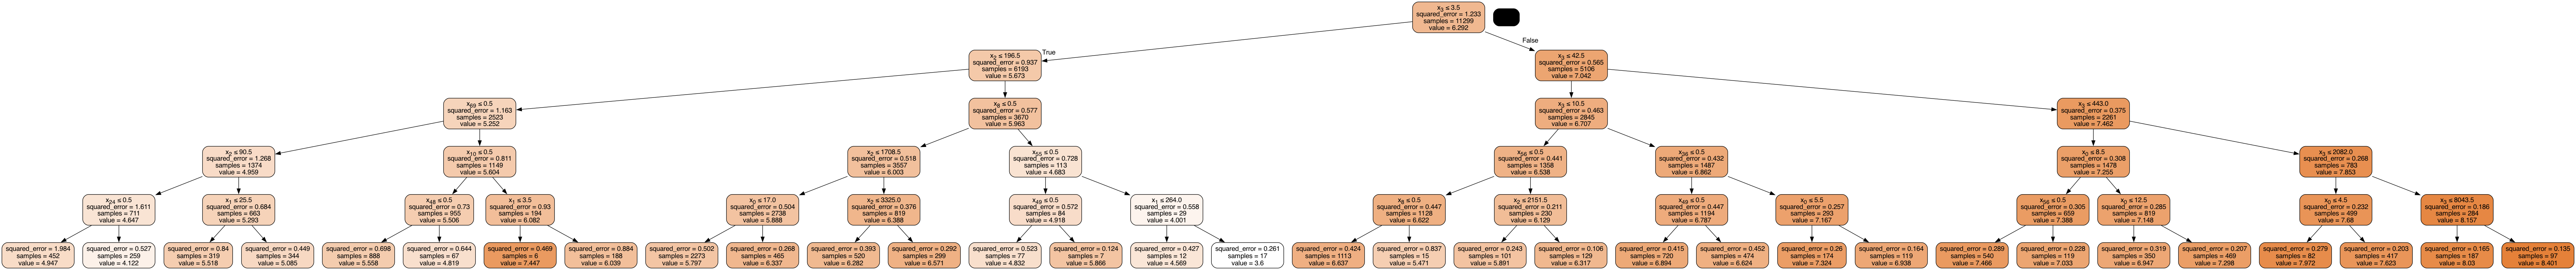

In [30]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(treeScore, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [31]:
print(f'R^2 for train set: {treeScore.score(X_train,y_train):0.3}\n\
For test set: {treeScore.score(X_test,y_test):0.3}')

R^2 for train set: 0.602
For test set: 0.584


In [32]:
print(f'RMSE for train set:\
 {np.sqrt(metrics.mean_squared_error(y_train, treeScore.predict(X_train))):0.3}\n\
For test set:\
 {np.sqrt(metrics.mean_squared_error(y_test, treeScore.predict(X_test))):0.3}')

RMSE for train set: 0.7
For test set: 0.709


Just in case, let's look at the results with cross-validation so that the model does not overfit:

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

treeCV = tree.DecisionTreeRegressor(max_depth = 5)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cv_results = cross_validate(treeCV, X, y, cv=cv, scoring='neg_root_mean_squared_error', return_train_score = True)
train_score = cv_results['train_score']
test_score = cv_results['test_score']
print(f'train: {train_score}\ntest: {test_score}')

train: [-0.69732409 -0.69835892 -0.69880819 -0.70112806 -0.6963372 ]
test: [-0.71223706 -0.69555817 -0.70424208 -0.71056888 -0.72240465]


In most cases the model is not much overfitted, from which it can be concluded that it is suitable for our prediction task. The RMSE metric varies around 0.7, which indicates good results for prediction.

### 2 model: what algorithm did you use, what results did you get

I will use a linear regression model:

In [14]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train,y_train)
reg.intercept_, reg.coef_

(5.915037685603452,
 array([ 1.10267913e-03, -1.12352744e-05,  9.97373880e-06, -2.49608558e-05,
         5.28866854e-02,  1.80504273e-01, -1.33776720e-01,  1.18202086e-01,
        -7.87986361e-01, -7.46756268e-02,  3.52315362e-01, -9.85900738e-02,
         1.84708526e-01,  4.12124017e-02, -2.70166112e-02,  2.17682447e-01,
         2.23311792e-01, -2.90975284e-01,  1.81682227e-01, -9.53059518e-02,
         1.70857935e-01,  2.27470351e-02,  1.24763802e-01,  2.73987185e-01,
         9.82555481e-02,  2.94652892e-01, -4.43830855e-02,  2.81836685e-01,
         1.80357862e-01,  7.29888592e-02,  3.97354626e-02,  1.50505035e-01,
         1.30244936e-01,  1.51681844e-01,  2.53155409e-01,  3.95031470e-02,
         2.46017656e-01,  3.65127437e-02,  2.18223213e-01,  1.06237540e-01,
         2.12351396e-01,  6.54861452e-02,  1.37398888e-01,  1.81889013e-01,
         7.01657234e-02, -8.26345964e-03, -7.95431285e-02, -6.06788831e-01,
        -5.54018979e-01, -1.40832700e-01, -5.13061652e-02, -1.457371

In [15]:
print(f'R^2 for train set: {reg.score(X_train,y_train):0.3}\n\
For test set: {reg.score(X_test,y_test):0.3}')

R^2 for train set: 0.465
For test set: 0.438


In [16]:
print(f'RMSE for train set:\
 {np.sqrt(metrics.mean_squared_error(y_train, reg.predict(X_train))):0.3}\n\
For test set:\
 {np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))):0.3}')

RMSE for train set: 0.812
For test set: 0.823


The linear regression model showed a relatively good result since there was no obvious overfitting. However, R^2 is not very high, so let's try to improve the linear regression model.

### 3 model

Let's log some numeric variables:

In [17]:
df_result['log_scored_by'] = np.log(df_result['scored_by'] + 1)
df_result['log_favorites'] = np.log(df_result['favorites'] + 1)
df_result['log_members'] = np.log(df_result['members'] + 1)

In [18]:
y = df_result.score
X = df_result.drop(columns = ['score', 'scored_by', 'members', 'favorites'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, random_state = 2)

In [19]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [20]:
print(f'R^2 for train set: {reg.score(X_train,y_train):0.3}\n\
For test set: {reg.score(X_test,y_test):0.3}')

R^2 for train set: 0.617
For test set: 0.605


In [21]:
print(f'RMSE for train set:\
 {np.sqrt(metrics.mean_squared_error(y_train, reg.predict(X_train))):0.3}\n\
For test set:\
 {np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))):0.3}')

RMSE for train set: 0.685
For test set: 0.697


The upgraded model is clearly better in terms of R^2 and RMSE metrics, and these indicators do not differ much between the training and test samples. On average, it is wrong by about 0.7, which is not bad, considering that the score is based on a 10-point scale.

### Which model did you choose as the final one and why?

As a final model I would prefer a regression tree - it shows the best result based on the RMSE metric among all of the built models. When solving the prediction problem, it is much better to rely on this metric. Although the R^2 of such a model turned out to be worse than that of linear regression, it is not a priority within the framework of the task (besides, this difference is not very large).